In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import threading
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.append('../')
import src.IQ as IQ


2023-11-19 01:33:46.336033: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 01:33:46.359961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 01:33:46.359983: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 01:33:46.360000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 01:33:46.364169: I tensorflow/core/platform/cpu_feature_g

In [2]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/admin")
BLE = myclient["BLE"]

def query(collection, filter:dict, addFrameColumn=True):
    df =  pd.DataFrame(list(collection.find(filter)))
    if addFrameColumn:
        df['frame'] = df.apply(lambda x: x['I'] + np.dot(x['Q'],1j), axis=1)
    return df.copy()

In [3]:
# Create a StandardScaler object
scaler = StandardScaler()
scaler2 = MinMaxScaler(feature_range=(0, 1))
# Assuming 'new_csv_features' is your data
def normalized(row):
    row = np.array(row)
    return scaler2.fit_transform(scaler.fit_transform(row.reshape(-1, 1)))

def fft_normalized(row):
    row = np.array(row)
    temp = np.fft.fft(row)[0:len(row)//2 + 1]

    amp = normalized(np.abs(temp))
    filtering = amp > np.average(amp)*.05
    angle = normalized(np.angle(temp))

    angle = angle[filtering] 
    angle = np.concatenate([angle,np.zeros(len(row)-len(angle))])
    amp = amp[filtering] 
    amp = np.concatenate([amp,np.zeros(len(row)-len(amp))])
    
    return np.concatenate([amp,angle])


In [4]:

filtering = {''}
df = query(BLE['onBody'], {'pos':'static','antenna_side':'left'})
min_length = df['frame'].apply(len).min()
df['frame'] = df['frame'].apply(lambda x: x[:min_length])
print(len(df['frame'][0]))
print(type(df['frame'][0]))

iq = IQ.IQ(Fc=2439810000+.1e4)

def configCreator(downSampleRate = 1, cutoff = 1e6):
    downSampleRate= max(downSampleRate, 1)
    return {                                      
            iq.gradient:{},
            iq.unwrapPhase:{},
            iq.phase:{}, 
            iq.butter:{'Fs': iq.Fs/downSampleRate, "cutoff": cutoff},
            iq.downSample:{'downSampleRate':downSampleRate, "shift": 0},
            iq.demodulate:{'Fs': iq.Fs},
           } 

methods = configCreator(downSampleRate=  1)
df['data'] = iq.apply(methods = methods, frame = df)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['dvc'], test_size=0.2, random_state=42)

X_train = tf.convert_to_tensor(X_train.tolist())
X_test =  tf.convert_to_tensor(X_test.tolist())
y_train =  tf.convert_to_tensor(y_train.tolist())
y_test = tf.convert_to_tensor(y_test.tolist())
####################################################################################
# df['normalized'] = df['predictor'].apply(lambda x: normalized(x))

df['normalized'] = df['data'].apply(lambda x: fft_normalized(x))
input_tensor_features = tf.convert_to_tensor(df['normalized'].tolist())

df['normalized'] = df['data']#.apply(lambda x: normalized(x))
output_tensor_features = tf.convert_to_tensor(df['normalized'].tolist())

data_shape = len(df['data'][0])



4022
<class 'numpy.ndarray'>


2023-11-19 01:34:00.035476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 01:34:00.039159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 01:34:00.039260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [6]:

# Assuming X_train, y_train, X_test, y_test are already prepared

# Normalize the data (if not already done)
# X_train, X_test = X_train / 255.0, X_test / 255.0

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(y_test_encoded.shape[1], activation='softmax'))  # 13 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=64, batch_size=64, validation_data=(X_test, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {accuracy}')

Epoch 1/64


2023-11-19 01:34:05.906941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-19 01:34:06.321084: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-19 01:34:06.404971: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-19 01:34:07.251281: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe9ccda4d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 01:34:07.251297: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-11-19 01:34:07.254579: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-19 01:34:07.299924: I ./tensorflow/compiler/jit/device_c

37/37 [==============================] - 7s 77ms/step - loss: 1.0872 - accuracy: 0.6623 - val_loss: 0.1570 - val_accuracy: 0.9779
Epoch 2/64
37/37 [==============================] - 2s 44ms/step - loss: 0.1241 - accuracy: 0.9749 - val_loss: 0.1107 - val_accuracy: 0.9881
Epoch 3/64
37/37 [==============================] - 2s 44ms/step - loss: 0.0485 - accuracy: 0.9911 - val_loss: 0.0898 - val_accuracy: 0.9898
Epoch 4/64
37/37 [==============================] - 2s 44ms/step - loss: 0.0327 - accuracy: 0.9940 - val_loss: 0.1071 - val_accuracy: 0.9864
Epoch 5/64
37/37 [==============================] - 2s 44ms/step - loss: 0.0167 - accuracy: 0.9970 - val_loss: 0.1185 - val_accuracy: 0.9881
Epoch 6/64
37/37 [==============================] - 2s 44ms/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.1107 - val_accuracy: 0.9847
Epoch 7/64
37/37 [==============================] - 2s 44ms/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.1226 - val_accuracy: 0.9881
Epoch 8/64
37/37 [======

In [11]:
z = model(X_test[0:100])
zz = pd.DataFrame(np.array(z))

# num_rows = zz.shape[0]

# # Plot each row
# for i in range(num_rows):
#     # plt.figure(figsize=(8, 4))  # Adjust the size as needed
#   plt.plot(zz.iloc[i, :])

# plt.show()
zz


2023-11-19 01:37:51.823988: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 196.29MiB (rounded to 205824000)requested by op Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-19 01:37:51.824063: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-11-19 01:37:51.824090: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 36, Chunks in use: 34. 9.0KiB allocated for chunks. 8.5KiB in use in bin. 320B client-requested in use in bin.
2023-11-19 01:37:51.824110: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 9, Chunks in use: 9. 4.5KiB allocated for chunks. 4.5KiB in use in bin. 4.2KiB client-requested in use in bin.
2023-11-19 01:37:51.824128: I tensorflow/tsl/framework/bfc_allo

ResourceExhaustedError: Exception encountered when calling layer 'conv1d' (type Conv1D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[100,1,4020,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D] name: 

Call arguments received by layer 'conv1d' (type Conv1D):
  • inputs=tf.Tensor(shape=(100, 4022, 1), dtype=float32)

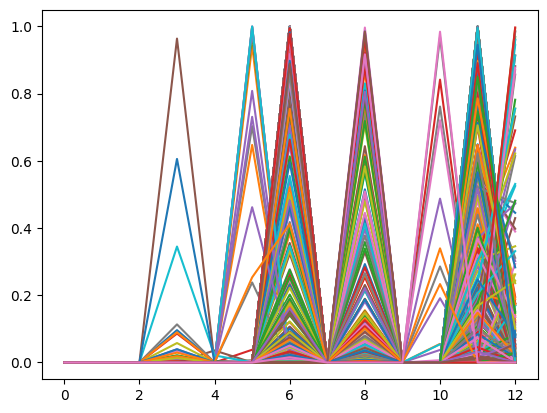

In [ ]:
df = query(BLE['offBody'], {'pos':'1','antenna':'1', 'dvc':'7'})
# min_length = df['frame'].apply(len).min()
df['frame'] = df['frame'].apply(lambda x: x[:min_length])
df['data'] = iq.apply(methods = methods, frame = df)

X_test = tf.convert_to_tensor(df['data'].tolist())

z = model(X_test)
zz = pd.DataFrame(np.array(z))

num_rows = zz.shape[0]

# Plot each row
for i in range(num_rows):
    # plt.figure(figsize=(8, 4))  # Adjust the size as needed
  plt.plot(zz.iloc[i, :])

plt.show()